## essentials

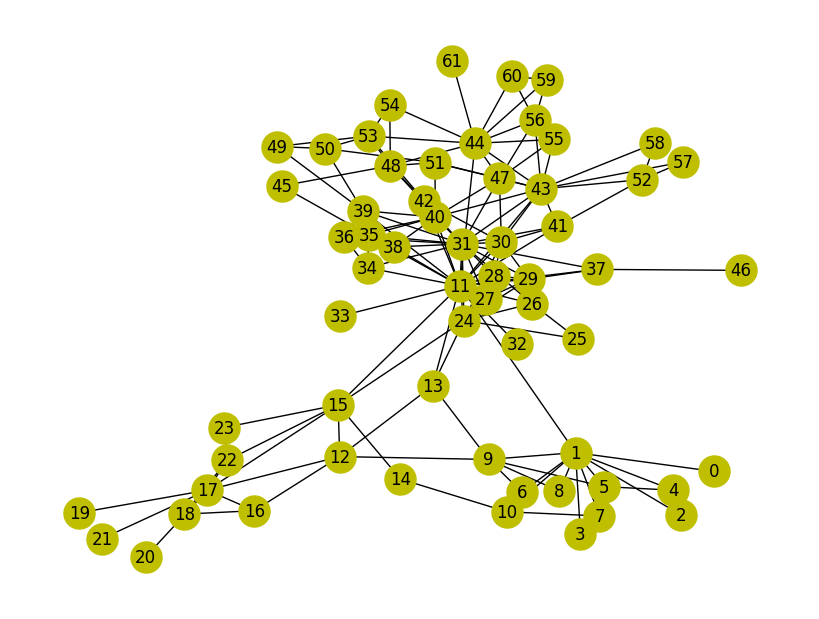

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

df = pd.read_csv('../data/edges.csv', skiprows=1, header=None)
# display(df)
edges = [tuple(x) for x in df.values]

G = nx.Graph()
G.add_edges_from(edges)
layout = nx.spring_layout(G, seed=42)
fig = plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='y', node_size=500, pos =layout)

## trial -1

### betweeness centrality sorted

In [2]:
betweenness = nx.betweenness_centrality(G)
betweeness_sorted = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
#access only the node names
betweeness_nodes = [x[0] for x in betweeness_sorted]
betweeness_nodes[:5]

[11, 1, 15, 44, 43]

In [3]:
#reading the csv file that contains the plci
df = pd.read_csv('../data/model_output_full.csv', skiprows=1, header=None)

betw = dict(zip(df[10], df[7]))
#sort them based on the values
betw_sorted = sorted(betw.items(), key=lambda x: x[1], reverse=True)
betw_nodes =[x[0] for x in betw_sorted]
betw_nodes[:5]

[11, 1, 15, 44, 43]

In [4]:
#do the same but for percolation on column 9
perc = dict(zip(df[10], df[9]))
perc_sorted = sorted(perc.items(), key=lambda x: x[1], reverse=True)
perc_nodes =[x[0] for x in perc_sorted]
perc_nodes[:5]

[17, 1, 31, 9, 29]

In [5]:
c=0
for i in range(62):
    if betw_nodes[i]!=betweeness_nodes[i]:
        print(betw_nodes[i],"on the %d position"%i)
        c+=1
c

4 on the 40 position
6 on the 41 position
8 on the 42 position
25 on the 43 position
27 on the 44 position
28 on the 45 position
55 on the 46 position
59 on the 47 position
2 on the 48 position
3 on the 49 position
32 on the 50 position
33 on the 51 position
23 on the 52 position
19 on the 53 position
20 on the 54 position
21 on the 55 position
46 on the 56 position
57 on the 57 position
58 on the 58 position


19

### Complex centrality sorted

### extraction

In [6]:
#reading the csv file that contains the plci
df = pd.read_csv('../data/model_output_full.csv', skiprows=1, header=None)
#putting col 10 as keys and col 4 as values in a dictionary
plci = dict(zip(df[10], df[4]))
#sort them based on the values
plci_sorted = sorted(plci.items(), key=lambda x: x[1], reverse=True)
plci_nodes =[x[0] for x in plci_sorted]

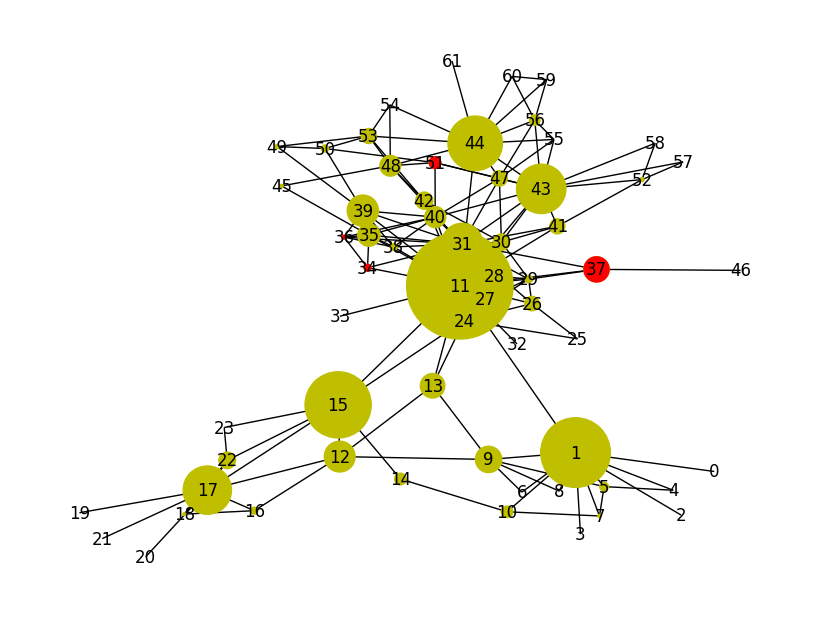

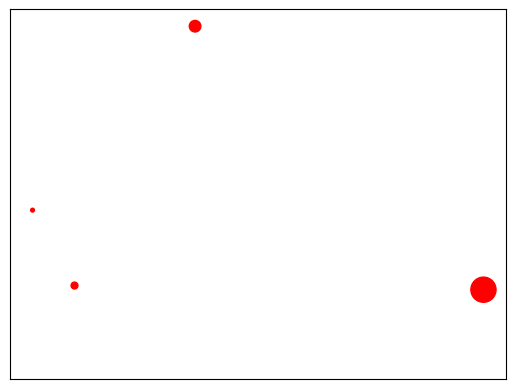

In [7]:
plci_nodes[:5]
#plot the graph and color the top 5 nodes based on plci and size based on betweeness

top_5_plci_nodes = plci_nodes[:5]
top_5_sizes = [betweenness[v] * 10000 for v in top_5_plci_nodes]

fig = plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='y', node_size=[v * 10000 for v in betweenness.values()], pos=layout)
nx.draw_networkx_nodes(G, pos=layout, nodelist=top_5_plci_nodes, node_color='r', node_size=top_5_sizes)
plt.show()
nx.draw_networkx_nodes(G, pos=layout, nodelist=top_5_plci_nodes, node_color='r', node_size=top_5_sizes)
plt.show()

### The attack 

In [8]:
def compute_lcc(G):
    if G.number_of_nodes() == 0:
        return 0
    else:
        max_comp= max(nx.connected_components(G), key=len)
        return len(max_comp)
    
def compute_i(G, i):
    if G.number_of_nodes() == 0:
        return 0
    else:
        max_comp= max(nx.connected_components(G), key=len)
        return len(max_comp)/i

def attack(G, sorted_nodes):
    LCC={}#key is the # of nnodes removed, value is the size of the largest connected component
    Inter={}
    fix_size=G.number_of_nodes()
    G_copy = G.copy()
    for i in range(len(sorted_nodes)):
        G_copy.remove_node(sorted_nodes[i])
        lcc = compute_lcc(G_copy)
        i_index= compute_i(G_copy, fix_size)
        LCC[i+1] = lcc
        Inter[i+1]=i_index
    return LCC, Inter

bet_attack =attack(G, betweeness_nodes)
plci_attack=attack(G, plci_nodes)
per_attack=attack(G, perc_nodes)
# compute_lcc(G)

In [9]:
degrees={}
for n in G.nodes():
    degrees[n]=G.degree(n)
# degrees
#srt degrees by keys NOT values
# degrees

In [37]:
#i wanna plot the bet_attack and plci_attack on same plot where keys are the x axis and values are on y
fig = plt.figure(figsize=(8, 6))
plt.plot(list(bet_attack.keys()), list(bet_attack.values()), label='Betweeness')
plt.plot(list(plci_attack.keys()), list(plci_attack.values()), label='PLCI')
plt.plot(list(per_attack.keys()), list(per_attack.values()), label='Percolation')
# plt.plot(list(degrees.keys()), list(degrees.values()), label='Degree')
plt.legend()
plt.xlabel('Number of nodes removed')
plt.ylabel('i_index')
plt.show()

AttributeError: 'tuple' object has no attribute 'keys'

<Figure size 800x600 with 0 Axes>

0.5241733033240997

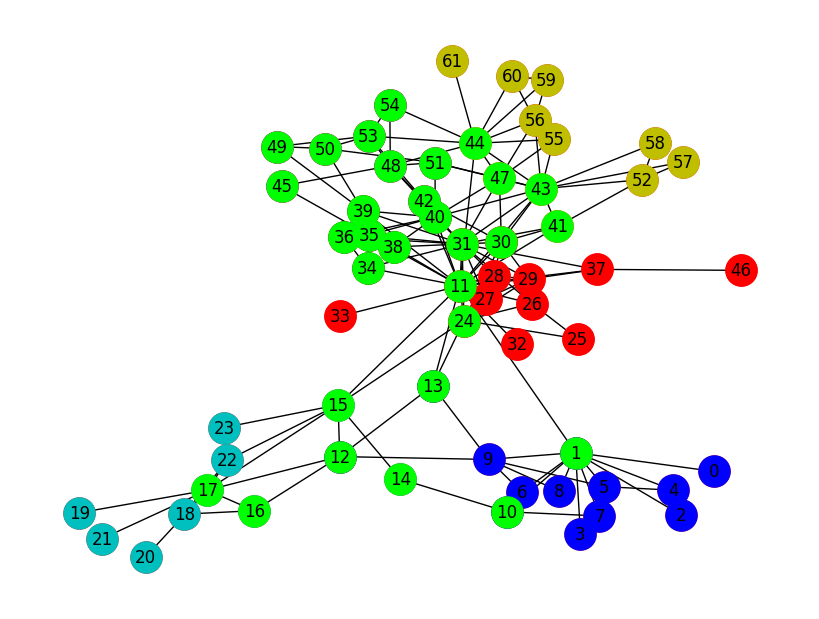

In [26]:
def get_boundary_nodes(G, partition):   
    '''takes graph and partiton - list of sets of nodes - as input and returns the boundary nodes in a list'''
    boundary_edges = set()
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i != j:
                boundary_edges.update(nx.edge_boundary(G, partition[i], partition[j]))

    b_nodes = []
    for i in range(len(boundary_nodes)):
        b_nodes.append(list(boundary_nodes)[i][0])
        b_nodes.append(list(boundary_nodes)[i][1])
    b_nodes = list(set(b_nodes))
    return b_nodes

#apply louvain on the ntework
partition = nx.community.louvain_communities(G, seed=10)
partition
#access boundary nodes
boundary_nodes = set()
for i in range(len(partition)):
    for j in range(len(partition)):
        if i != j:
            boundary_nodes.update(nx.edge_boundary(G, partition[i], partition[j]))

#turn all number in the tuples in boundary_nodes to elements of list b_nodes
b_nodes = []
for i in range(len(boundary_nodes)):
    b_nodes.append(list(boundary_nodes)[i][0])
    b_nodes.append(list(boundary_nodes)[i][1])
#make all elements unique
b_nodes = list(set(b_nodes))
#color boundary nodes in green and the rest in red
# fig = plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_color='r', node_size=500, pos=layout)
# nx.draw_networkx_nodes(G, pos=layout, nodelist=b_nodes, node_color='g', node_size=500)

#color graph based on the partition
fig = plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='r', node_size=500, pos=layout)
#create a lis of 20 colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink', 'brown', 'purple', 'gray', 'olive', 'cyan', 'lime', 'teal', 'lavender', 'turquoise', 'tan'] 
for i in range(len(partition)):
    nx.draw_networkx_nodes(G, pos=layout, nodelist=list(partition[i]), node_color=colors[i], node_size=500)
nx.draw_networkx_nodes(G, pos=layout, nodelist=b_nodes, node_color='lime', node_size=500)

#compute the modularity of the partition
nx.community.quality.modularity(G, partition)

In [ ]:
def get_boundary_nodes(G, partition):   
    '''takes graph and partiton - list of sets of nodes - as input and returns the boundary nodes in a list'''
    boundary_edges = set()
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i != j:
                boundary_edges.update(nx.edge_boundary(G, partition[i], partition[j]))

    b_nodes = []
    for i in range(len(boundary_nodes)):
        b_nodes.append(list(boundary_nodes)[i][0])
        b_nodes.append(list(boundary_nodes)[i][1])
    b_nodes = list(set(b_nodes))
    return b_nodes


def community_attack(g:nx.Graph, partition:list, sorted_central:list):
    '''
    take a graph, the partition done after using a community based algorithm, and a list of nodes sorted based on their centrality
    returns: dictionaries where keys are the number of nodes removed and values are the LCCs normalized/efficiency...
    '''
    #stopping criteria is either LCC=0 or boundary nodes left are {}
    G=g.copy()

    boundary_nodes = get_boundary_nodes(g, partition)
    B=len(boundary_nodes ); N=G.number_of_nodes()

    LCC={}
    Inter={}
    Eff={}
    R=[]
    sorted_central_q=sorted_central.copy()  

    for i in range(N): #looping through all nodes
        if len(boundary_nodes) !=0:
            if sorted_central[i] in boundary_nodes:
                G.remove(sorted_central[i])
                sorted_central_q.remove(sorted_central[i])
                boundary_nodes.remove(sorted_central[i])
                B-=1
            else: 
                continue
        else: #now we have N-B nodes left in the queue
            G.remove(sorted_central_q[0]) #they're sorted and everytime im removing the first one
            sorted_central_q.remove(sorted_central_q[0])
        lcc = compute_lcc(G)
        i_index= compute_i(G, N)
        eff = 
            

            




In [38]:
# def compute_local_bewteenness(G, partition):
#     '''takes a graph and a partition as input and returns a dictionary with nodes as keys and local betweenness as values'''
#     local_betweenness = {}
#     for i in range(len(partition)):
#         sub = G.subgraph(partition[i])
#         betweenness = nx.betweenness_centrality(sub)    
#         local_betweenness.update(betweenness)
#     return local_betweenness

# compute_local_bewteenness(G, partition)